### 1. Download and unzip data

In [1]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

--2023-05-26 04:40:46--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.27.123, 52.217.84.68, 52.216.152.76, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.27.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  12.8MB/s    in 50s     

2023-05-26 04:41:37 (12.0 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2023-05-26 04:41:37--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.11.155, 52.216.35.97, 52.217.112.97, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challen

### 2. Make training and test image folders by training and test csv files

In [2]:
import os
import shutil
import pandas as pd
import numpy as np

if not os.path.exists("./train"):
    os.makedirs("./train")
    os.makedirs("./train/benign")
    os.makedirs("./train/malignant")
if not os.path.exists("./val"):
    os.makedirs("./val")
    os.makedirs("./val/benign")
    os.makedirs("./val/malignant")

df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)

N_train_val = len(img_lis) # 900
N_labeltrain = 270 
N_val = 90 

shuffle_ix = np.random.permutation(np.arange(N_train_val))
ix_labeltrain = shuffle_ix[:N_labeltrain]
ix_val = shuffle_ix[N_labeltrain:N_labeltrain + N_val]
ix_unlabeltrain = shuffle_ix[N_labeltrain + N_val:]

print(N_labeltrain, len(ix_labeltrain))
print(N_val, len(ix_val))
print(N_train_val - N_labeltrain - N_val, len(ix_unlabeltrain))


for i in ix_labeltrain:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")

for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")  
    
if not os.path.exists("./unlabel"):
    os.makedirs("./unlabel")
    os.makedirs("./unlabel/unknown")

for i in ix_unlabeltrain:
    name = img_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./unlabel/unknown/"+name+".jpg")
    

270 270
90 90
540 540


##A. Pseudo Labeling

### A1. Build training and test loaders for Pseudo Labeling

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train = './train'
train_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_val = './val'
root_NL = './unlabel'
test_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_NL_set(batch_size=12):
    train_dataset = ImageFolder(root_train, transform=train_transform)
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )
    
    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    
    NL_dataset = ImageFolder(root_NL, transform=test_transform)
    loader_NL = torch.utils.data.DataLoader(
        dataset=NL_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    return loader_train, loader_val, loader_NL

batch_size = 12
loader_train, loader_val, loader_NL = get_train_NL_set(batch_size)

### A2. Build the network for Pseudo Labeling


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x
def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict() 
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

class Model1(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(Model1, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model1 = Model1(resnet50, 1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 278MB/s]


###A3. Train and test the model for Pseudo Labeling

In [5]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 5
use_cuda = True
if use_cuda:
    model1 = model1.cuda()
    
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.6, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        alpha = self.alpha
        gamma = self.gamma
        loss = - alpha * (1 - logits) ** gamma * target * torch.log(logits) - \
               (1 - alpha) * logits ** gamma * (1 - target) * torch.log(1 - logits)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

criterion = BCEFocalLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)


loss_list = []
auc_train_list = []
auc_test_list = []
acc_train_list = []
acc_test_list = []

for epoch in range(max_epoch):
    train_lbl, train_pred = [], []
    running_loss = 0.0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))
    model1.train()
    for data in tqdm(loader_train):
        optimizer.zero_grad()
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model1(images)[:,0]
        outputs = F.sigmoid(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    loss = running_loss / len(loader_train)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)
    

    # evaluate on validation set
    model1.eval()
    test_lbl, test_pred = [], []
    for data in loader_val:
        test_images, test_labels = data
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        test_outputs = model1(test_images)[:, 0]
        test_outputs = F.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores
        
    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    auc_test_list.append(test_auc)
    acc_test_list.append(test_acc)
    print(loss, train_auc, test_auc)

#### evaluate on test set
model1.eval()
test_pred = []
for data in loader_NL:
    test_images, garbage = data
    if use_cuda:
        test_images = test_images.cuda()
    test_outputs = model1(test_images)[:, 0]
    test_outputs = F.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    test_pred += y_scores
        
test_pred = np.array(test_pred)
NL_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0


 -- Epoch 1/5


100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


0.06996359303593636 0.5454545454545455 0.6728888888888889
 -- Epoch 2/5


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


0.06020359727351562 0.716955602536998 0.7128888888888888
 -- Epoch 3/5


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


0.052312355974446174 0.8166596194503171 0.7288888888888889
 -- Epoch 4/5


100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


0.049025507643818855 0.8384778012684989 0.7226666666666667
 -- Epoch 5/5


100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


0.04216045602832152 0.9024947145877378 0.7431111111111111


### A4. Plot the training and test curves

Text(0.5, 1.0, 'ACC')

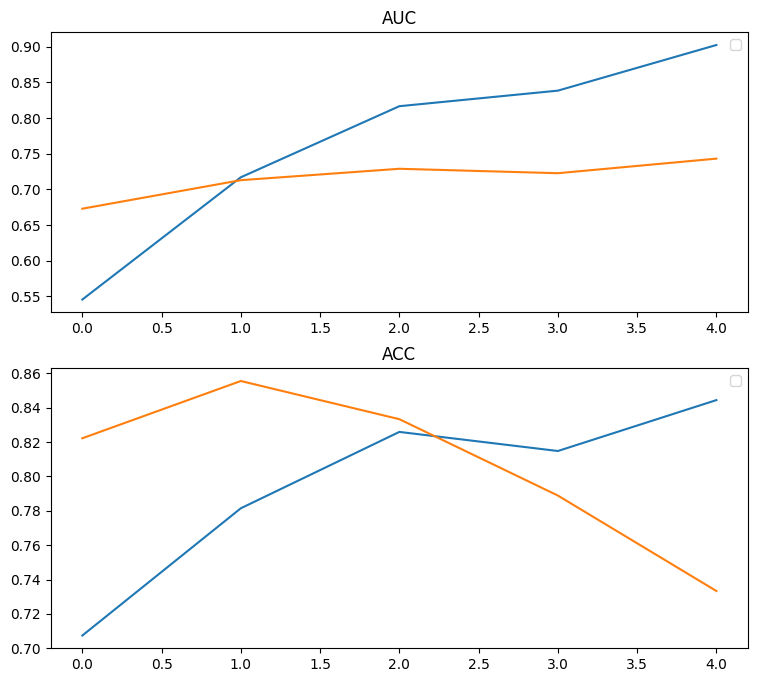

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(auc_train_list)
plt.plot(auc_test_list)
plt.legend()
plt.title("AUC")

plt.subplot(2,1,2)
plt.plot(acc_train_list)
plt.plot(acc_test_list)
plt.legend()
plt.title("ACC")

Text(0.5, 1.0, 'Train Loss')

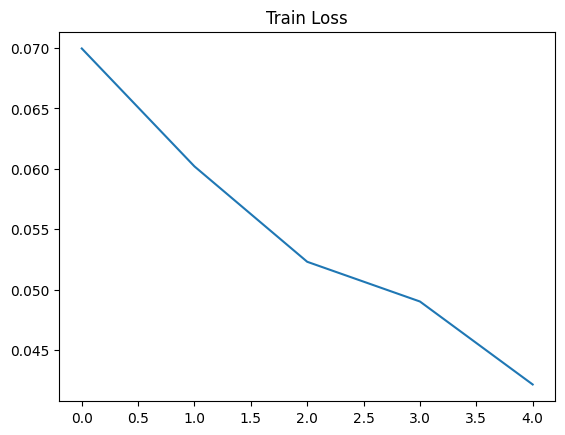

In [7]:
plt.plot(loss_list)
plt.title("Train Loss")

## B. Classification

### B1. Build training and test loaders for Classification

In [8]:
for i in ix_unlabeltrain:
    j = 0
    name, label = img_lis[i], NL_pred_lbl[j]
    j += 1
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")


if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")

df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

### B2. Build the network for Classification

In [9]:
root_train = './train'
train_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_val = './val'
root_test = './test'
test_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size=12):
    train_dataset = ImageFolder(root_train, transform=train_transform)
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )
    
    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    return loader_train, loader_val, loader_test
    
batch_size = 12
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

In [10]:
class Model2(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(Model2, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

model2 = Model2(resnet50, 1)

### B3. Model Training and Testing

In [11]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 10
use_cuda = True
if use_cuda:
    model2 = model2.cuda()
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.6, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        alpha = self.alpha
        gamma = self.gamma
        loss = - alpha * (1 - logits) ** gamma * target * torch.log(logits) - \
               (1 - alpha) * logits ** gamma * (1 - target) * torch.log(1 - logits)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

criterion = BCEFocalLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)


loss_list = []
auc_train_list = []
auc_test_list = []
acc_train_list = []
acc_test_list = []
for epoch in range(max_epoch):
    train_lbl, train_pred = [], []
    running_loss = 0.0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))
    model2.train()
    for data in tqdm(loader_train):
        optimizer.zero_grad()
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model2(images)[:,0]
        outputs = F.sigmoid(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    loss = running_loss / len(loader_train)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)
    

    # evaluate on validation set
    model2.eval()
    test_lbl, test_pred = [], []
    for data in loader_test:
        test_images, test_labels = data
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        test_outputs = model2(test_images)[:, 0]
        test_outputs = F.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores
        
    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    auc_test_list.append(test_auc)
    acc_test_list.append(test_acc)
    print(loss, train_auc, test_auc)



#### evaluate on test set
model2.eval()
test_lbl, test_pred = [], []
for data in loader_val:
    test_images, test_labels = data
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = model2(test_images)[:, 0]
    test_outputs = F.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores
        
test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print(test_auc, test_acc)

 -- Epoch 1/10


100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


0.03557745869928861 0.6903552077062011 0.697017543859649
 -- Epoch 2/10


100%|██████████| 68/68 [00:56<00:00,  1.19it/s]


0.028656176270862276 0.8180132450331126 0.7133771929824563
 -- Epoch 3/10


100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


0.02506517745581839 0.8811318482841661 0.7097368421052632
 -- Epoch 4/10


100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


0.01978025764829534 0.9373389524382901 0.7252631578947369
 -- Epoch 5/10


100%|██████████| 68/68 [00:58<00:00,  1.15it/s]


0.015829744200934383 0.9661408789885612 0.704517543859649
 -- Epoch 6/10


100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


0.012509226555052651 0.98051776038531 0.7171491228070175
 -- Epoch 7/10


100%|██████████| 68/68 [00:57<00:00,  1.18it/s]


0.010932782317361082 0.9844190246839253 0.6928947368421052
 -- Epoch 8/10


100%|██████████| 68/68 [00:59<00:00,  1.14it/s]


0.008399539535543333 0.9898133654425045 0.6772807017543859
 -- Epoch 9/10


100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


0.010221551601288785 0.9872847682119206 0.689780701754386
 -- Epoch 10/10


100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


0.014163741581689785 0.9613004214328718 0.6673245614035088
0.4862222222222222 0.8


### B4. Plot the training and test curves

Text(0.5, 1.0, 'ACC')

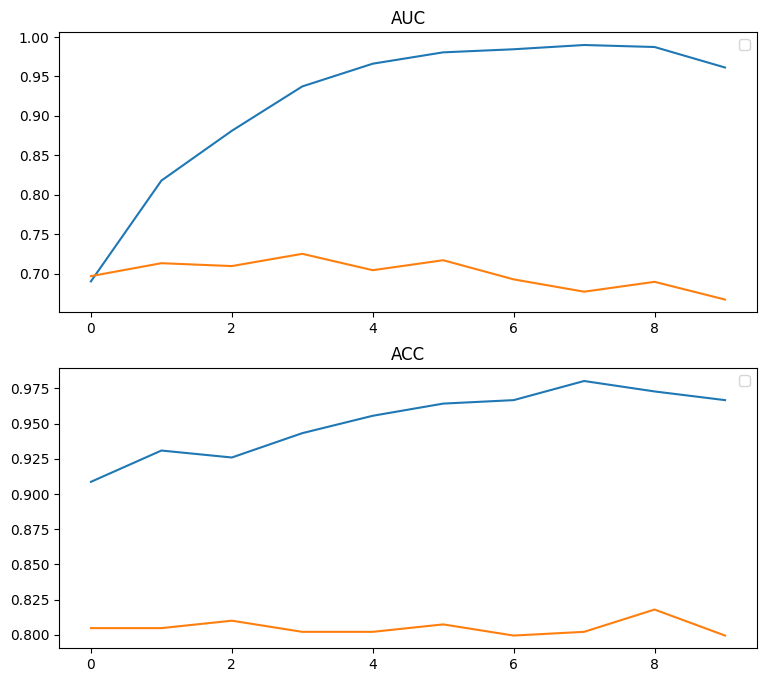

In [12]:
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(auc_train_list)
plt.plot(auc_test_list)
plt.legend()
plt.title("AUC")

plt.subplot(2,1,2)
plt.plot(acc_train_list)
plt.plot(acc_test_list)
plt.legend()
plt.title("ACC")

Text(0.5, 1.0, 'Train Loss')

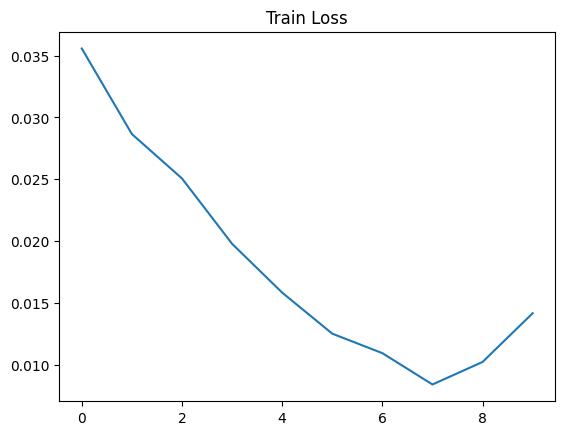

In [13]:
plt.plot(loss_list)
plt.title("Train Loss")